# SVM: Different kernels

The dual form of the SVM allows to make predictions based on the inner product between supported vectors and the input features. The inner product can be replaced with a kernel function. Depending on the kernel used, its result may be equal to that of an inner product of the data in a higher dimensional space. This is useful because in a higher dimensional space the data is more likely to be separable, and because the product on this space is implicit it does not brings the major drawback of computational cost.

The solution of the SVM in its dual form is:
$$
f(x) = sign(\sum_{i=1}^N{\hat{\alpha}_iy_iK(x, x_i)} + \beta_0),
$$

s.t. $0\leq\alpha_i\leq C$, where $\alpha$ are the Lagrange multipliers, $\beta_0$ is the intercept and $C$ is the cost parameter.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("..")
from models.svm import SVM
from utils.datasets import blobs_classification_dataset, radial_classification_dataset
from utils.datasets import spiral_classification_dataset
from utils.visualization import plot_decision_boundary

In [2]:
%matplotlib inline

# Turn interactive plotting off
plt.ioff()

# Reproducibility
np.random.seed(1)

## Linear kernel

This kernel performs the traditional dot product so with it, the solution ressembles that of the primal form of the SVM. It separates the data with a stright line as decision boundary.

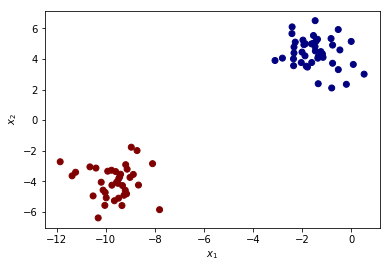

In [3]:
(x_train, y_train), (x_test, y_test) = blobs_classification_dataset(features=2, classes=2)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

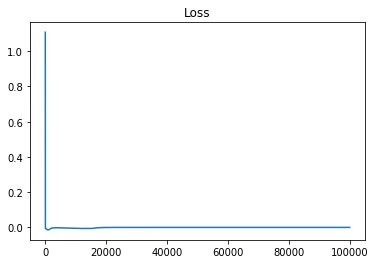

In [4]:
model = SVM(C=10000)
loss = model.fit(x_train, y_train, iterations=100000, learning_rate=0.01)

plt.plot(loss[1:])
plt.title('Loss')
plt.show();

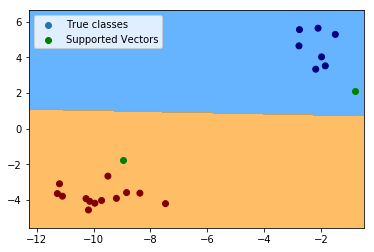

In [5]:
ax = plot_decision_boundary(model.predict,
                            x_range=[x_test[:, 0].min()-1, x_test[:, 0].max()+1],
                            y_range=[x_test[:, 1].min()-1, x_test[:, 1].max()+1])
# Plot test data
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap='jet', label='True classes')

# Plot supported vectors
ax.scatter(model.supported_vectors[:, 0], model.supported_vectors[:, 1], color='green', label='Supported Vectors')
ax.legend()
ax.set_xlim(x_test[:, 0].min()-1, x_test[:, 0].max()+1)
ax.set_ylim(x_test[:, 1].min()-1, x_test[:, 1].max()+1)
plt.show()

## Quadratic kernel

Data is not always lineary-separable. But it may be separable in a higher dimensional space. Take for instance the next classification task: 

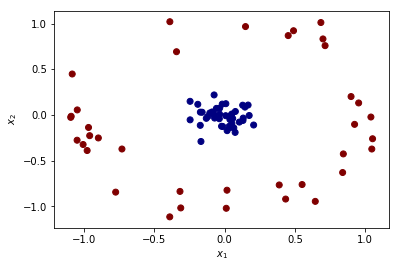

In [9]:
(x_train, y_train), (x_test, y_test) = radial_classification_dataset()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.show()

In this case the data is not separable with a line, but it is with a curve. Mapping the data from the actual $\langle x_1, x_2 \rangle$ into a higher dimensional space like $\langle 1, \sqrt{2}x_1, \sqrt{2}x_2, \sqrt{2}x_1x_2, x_1^2, x_2^2 \rangle$ would make the data linear separable again. In fact we would only need the las to dimensions:

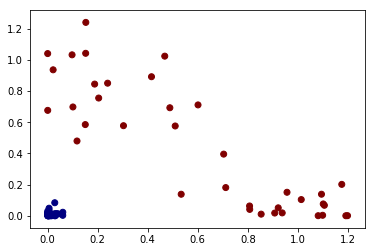

In [10]:
plt.scatter(x_train[:, 0]**2, x_train[:, 1]**2, c=y_train, cmap='jet')
plt.show()

But why then this specific space? This is because the dot product of vectors $[x_1, x_2], [y_1, y_2]$ in this space results in: $1 + 2x_1y_1 + 2x_2y_2 + 2x_1y_1x_2y_2 + x^2_1y^2_1 + x^2_2y^2_2 = (x_1y_1 + x_2y_2 + 1)^2$.
This is called the quadratic kernel, this function computes the dot product in that higher dimensional space avoiding to explictely mapping to it, just based on the dot product of the original space.

This kernel is a specific case of the polynomial kernel defined as:
$$
K(x, y) = (x^Ty + 1)^d,
$$
where $d$ is the degree of the polynomial.

### Solving the SVM

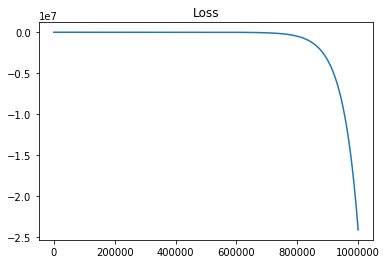

In [11]:
quadratic_model = SVM(kernel='quadratic', C=1000000)
loss = quadratic_model.fit(x_train, y_train, iterations=1000000, learning_rate=0.001)

plt.plot(loss[1:])
plt.title('Loss')
plt.show();

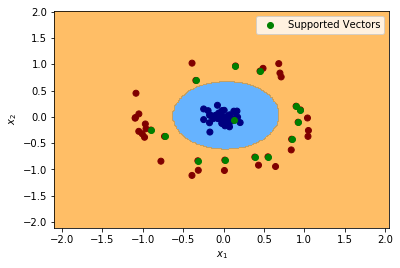

In [12]:
ax = plot_decision_boundary(quadratic_model.predict,
                            x_range=[x_train[:, 0].min()-1, x_train[:, 0].max()+1],
                            y_range=[x_train[:, 1].min()-1, x_train[:, 1].max()+1])
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
# Plot supported vectors
ax.scatter(quadratic_model.supported_vectors[:, 0], quadratic_model.supported_vectors[:, 1], color='green', label='Supported Vectors')
ax.legend()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

## Radial Basis Kernel

The radial basis kernel is defined as:
$$
K(x, y) = exp(-\gamma\|x-y\|^2),
$$

where $\gamma$ is a free parameter that may be tuned.

Taking a look at the kernel function we see that it returns a similarity measure based on the euclidean distance between the 2 points. The negative exponential returns a similarity of $1$ when the distance between the points is $0$, and decreases with the increment of distance. How much does the similarity decreases is controlled by $\gamma$, a high value means that with a small distance between points the similarity rapidly falls near $0$. On the other hand, a small $\gamma$ makes changes in distance to have less impact on the resulting similarity. This gives us some insight about the role of $\gamma$, it gives us some control over the smoothness of the decision boundary. 

A high value of $\gamma$ will give more importance to difference in distance to the supported vectors, resulting in a decision boundary greatly shaped by each individual supported vector, which can lead to overfitting the data. As $\lambda$ decreases, similarities will tend to normalize giving less importance to small differences in distance and smoothening the decision boundary. On the extreme case, with a very small value of $\lambda$, the kernel function might return scores too similar between each other making it impossible to discriminate between classes.

It can be show that the feature space of this kernel has an infinite number of dimensions. This allows to model more complex distributions like the following:

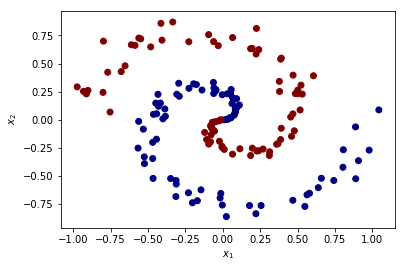

In [13]:
(x_train, y_train), (x_test, y_test) = spiral_classification_dataset(samples=200, radius=1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

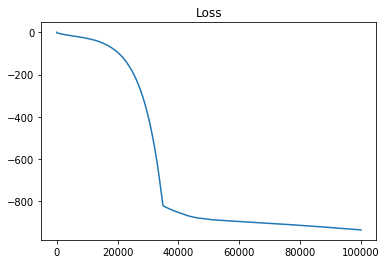

In [27]:
rbf_model = SVM(kernel='rbf', gamma=5, C=100)

loss = rbf_model.fit(x_train, y_train, iterations=100000, learning_rate=0.1)

plt.plot(loss[1:])
plt.title('Loss')
plt.show();

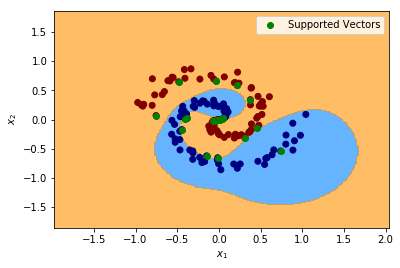

In [28]:
ax = plot_decision_boundary(rbf_model.predict,
                            x_range=[x_train[:, 0].min()-1, x_train[:, 0].max()+1],
                            y_range=[x_train[:, 1].min()-1, x_train[:, 1].max()+1])
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
# Plot supported vectors
ax.scatter(rbf_model.supported_vectors[:, 0], rbf_model.supported_vectors[:, 1], color='green', label='Supported Vectors')
ax.legend()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [33]:
rbf_model_analytic = SVM(kernel='rbf', gamma=10, C=1000)
rbf_model_analytic.fit_analytic(x_train, y_train)

C:\Users\sergi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\sergi\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


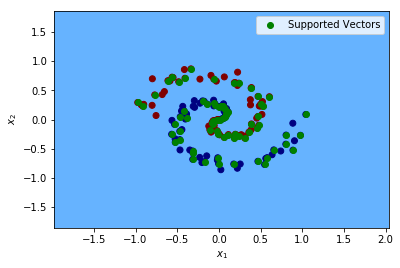

In [34]:
ax = plot_decision_boundary(rbf_model_analytic.predict,
                            x_range=[x_train[:, 0].min()-1, x_train[:, 0].max()+1],
                            y_range=[x_train[:, 1].min()-1, x_train[:, 1].max()+1])
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='jet')
# Plot supported vectors
ax.scatter(rbf_model_analytic.supported_vectors[:, 0], rbf_model_analytic.supported_vectors[:, 1], color='green', label='Supported Vectors')
ax.legend()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()